In [2]:
import xarray as xr
import sys
import xesmf as xe
import pickle
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/')
import commonera_utils as ce_utils 

In [3]:
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [4]:
def sub_arctic_plot(fig,ax,VAR1,LAT,LON,TITLE1,MAX1,colorbar=True,extent=True):
    var1, lon1 = add_cyclic_point(VAR1, coord=LON)
    new_lon2d, new_lat2d = np.meshgrid(lon1, LAT)
    if extent is True: 
        ax.set_extent([-150, 140, 50, 90], crs=ccrs.PlateCarree())
    ax.gridlines(linestyle='--')
    ax.add_feature(cfeature.LAND, facecolor=(1, 1, 1))
    cs = ax.pcolormesh(new_lon2d, new_lat2d, var1, 
                       vmin=-MAX1, vmax=MAX1, cmap=plt.cm.RdBu_r, 
                       transform=ccrs.PlateCarree())
    ax.coastlines(resolution='110m', linewidth=0.5)
    if colorbar is True:
        plt.colorbar(cs, ax=ax)
    ax.set_title(TITLE1)

In [5]:
proj = dict(projection=ccrs.Stereographic(central_latitude=90,
                                          central_longitude=-45,
                                          true_scale_latitude=0.1))

In [6]:
nsidc_mask_dir = '/home/disk/eos8/ed/Greg_proposal/'
nsidc_mask_file = 'sio_mask.nc'

nsidc_regions = xr.open_dataset(nsidc_mask_dir+nsidc_mask_file)

nsidc_regions.rename({'nx':'nj','ny':'ni'}, inplace=True)
nsidc_regions.mask.plot(levels=len(nsidc_regions.region_names),cmap='tab20')


ValueError: cannot specify both keyword and positional arguments to .rename

In [7]:
for i in range(len(nsidc_regions.region_names)):
    print(str(i+1)+ ' ' + str(nsidc_regions.region_names[i].values)[2:-3])

1 Ice-free Oceans
2 Sea of Okhotsk 
3 Bering         
4 Hudson Bay     
5 St John        
6 Baffin Bay     
7 East Greeland S
8 Barents Sea    
9 Kara Sea       
10 Laptev Sea     
11 East Siberian S
12 Chukchi Sea    
13 Beaufort Sea   
14 Canadian Island
15 Central Arctic 
16 null           
17 null           
18 null           
19 null           
20 land           
21 land outline   


In [8]:
regions_list = ['Sea of Okhotsk','Bering','Hudson Bay','St John','Baffin Bay',
                'East Greeland','Barents Sea','Kara Sea','Laptev Sea','East Siberian',
                'Chukchi Sea','Beaufort Sea', 'Canadian Island', 'Central Arctic']

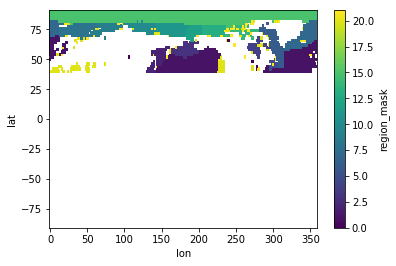

In [9]:
reg_filename = 'regionmask_surfaceareacell_2x2_grid.nc'
reg_mask = xr.open_dataset(reg_filename)
reg_mask.region_mask.plot()

In [10]:
output_dir_ccsm4 = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/ccsm4/'
output_file_ccsm4 = 'sic_ccsm4_anrecon_0_2000_pages2kv2_inf2_6_loc15000_iter0.pkl'

niter = 10

[sic_lalo_allit_ccsm4, tas_lalo_allit_ccsm4, sic_ens_var_allit_ccsm4, 
 nobs_allit_ccsm4, sia_ens_allit_ccsm4, sie_ens_allit_ccsm4, Ye_assim_allit_ccsm4, 
 Ye_assim_coords_allit_ccsm4, Xb_inflate_allit_ccsm4, recon_years, 
 proxy_assim_loc_allit_ccsm4] = ce_utils.load_recon_allit(output_dir_ccsm4,output_file_ccsm4,niter)

sic_lalo_ensmn = np.nanmean(sic_lalo_allit_ccsm4,axis=3)

In [290]:
output_dir_ccsm4 = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/mpi/'
output_file_ccsm4 = 'sic_mpi_anrecon_0_2000_pages2kv2_inf1_8_loc15000_iter0.pkl'

niter = 10

[sic_lalo_allit_ccsm4, tas_lalo_allit_ccsm4, sic_ens_var_allit_ccsm4, 
 nobs_allit_ccsm4, sia_ens_allit_ccsm4, sie_ens_allit_ccsm4, Ye_assim_allit_ccsm4, 
 Ye_assim_coords_allit_ccsm4, Xb_inflate_allit_ccsm4, recon_years, 
 proxy_assim_loc_allit_ccsm4] = ce_utils.load_recon_allit(output_dir_ccsm4,output_file_ccsm4,niter)

sic_lalo_ensmn = np.nanmean(sic_lalo_allit_ccsm4,axis=3)

In [295]:
sie_ensmn = np.nanmean(np.nanmean(sie_ens_allit_ccsm4,axis=1),axis=1)
sia_ensmn = np.nanmean(np.nanmean(sia_ens_allit_ccsm4,axis=1),axis=1)

In [296]:
if sic_lalo_ensmn.max() > 1.0: 
    sic_lalo_ensmn = sic_lalo_ensmn/100.0

sic_sample = xr.DataArray(sic_lalo_ensmn, dims=["time","lat","lon"],
                          coords={"time": np.array(recon_years),
                                  "lat": reg_mask.lat.lat.values, 
                                  "lon":reg_mask.lon.values})

sie = np.where(sic_lalo_ensmn>0.15,1.0,0.0)

sie_sample = xr.DataArray(sie, dims=["time","lat","lon"],
                          coords={"time": np.array(recon_years),
                                  "lat": reg_mask.lat.lat.values, 
                                  "lon":reg_mask.lon.values})

In [297]:
areacello_byreg=reg_mask.cell_area.where(reg_mask.region_mask==13)/(1e6)
areacello_byreg=reg_mask.cell_area.where(reg_mask.region_mask==nreg+1)/(1e6)

In [298]:
regional_sic = {}
regional_sie = {}
regional_tot_area = {}

horizdims = reg_mask.cell_area.dims
for nreg,reg in enumerate(regions_list):
    areacello_byreg=reg_mask.cell_area.where(reg_mask.region_mask==nreg+1)/(1e6)
    regional_sic[reg] = (sic_sample*areacello_byreg).sum(dim=['lat','lon']).values
    regional_sie[reg] = (sie_sample*areacello_byreg).sum(dim=['lat','lon']).values
    regional_tot_area[reg] = areacello_byreg.sum(dim=['lat','lon']).values
    print(str(nreg+1)+', '+reg+", "+str(np.round(regional_tot_area[reg],1)))

1, Sea of Okhotsk, 19380209.2
2, Bering, 1998054.5
3, Hudson Bay, 2012878.9
4, St John, 1007115.5
5, Baffin Bay, 555404.1
6, East Greeland, 2492221.8
7, Barents Sea, 2801377.0
8, Kara Sea, 1593766.9
9, Laptev Sea, 795256.4
10, East Siberian, 863230.9
11, Chukchi Sea, 1341956.4
12, Beaufort Sea, 798272.0
13, Canadian Island, 890978.1
14, Central Arctic, 577895.3


(9, 18)

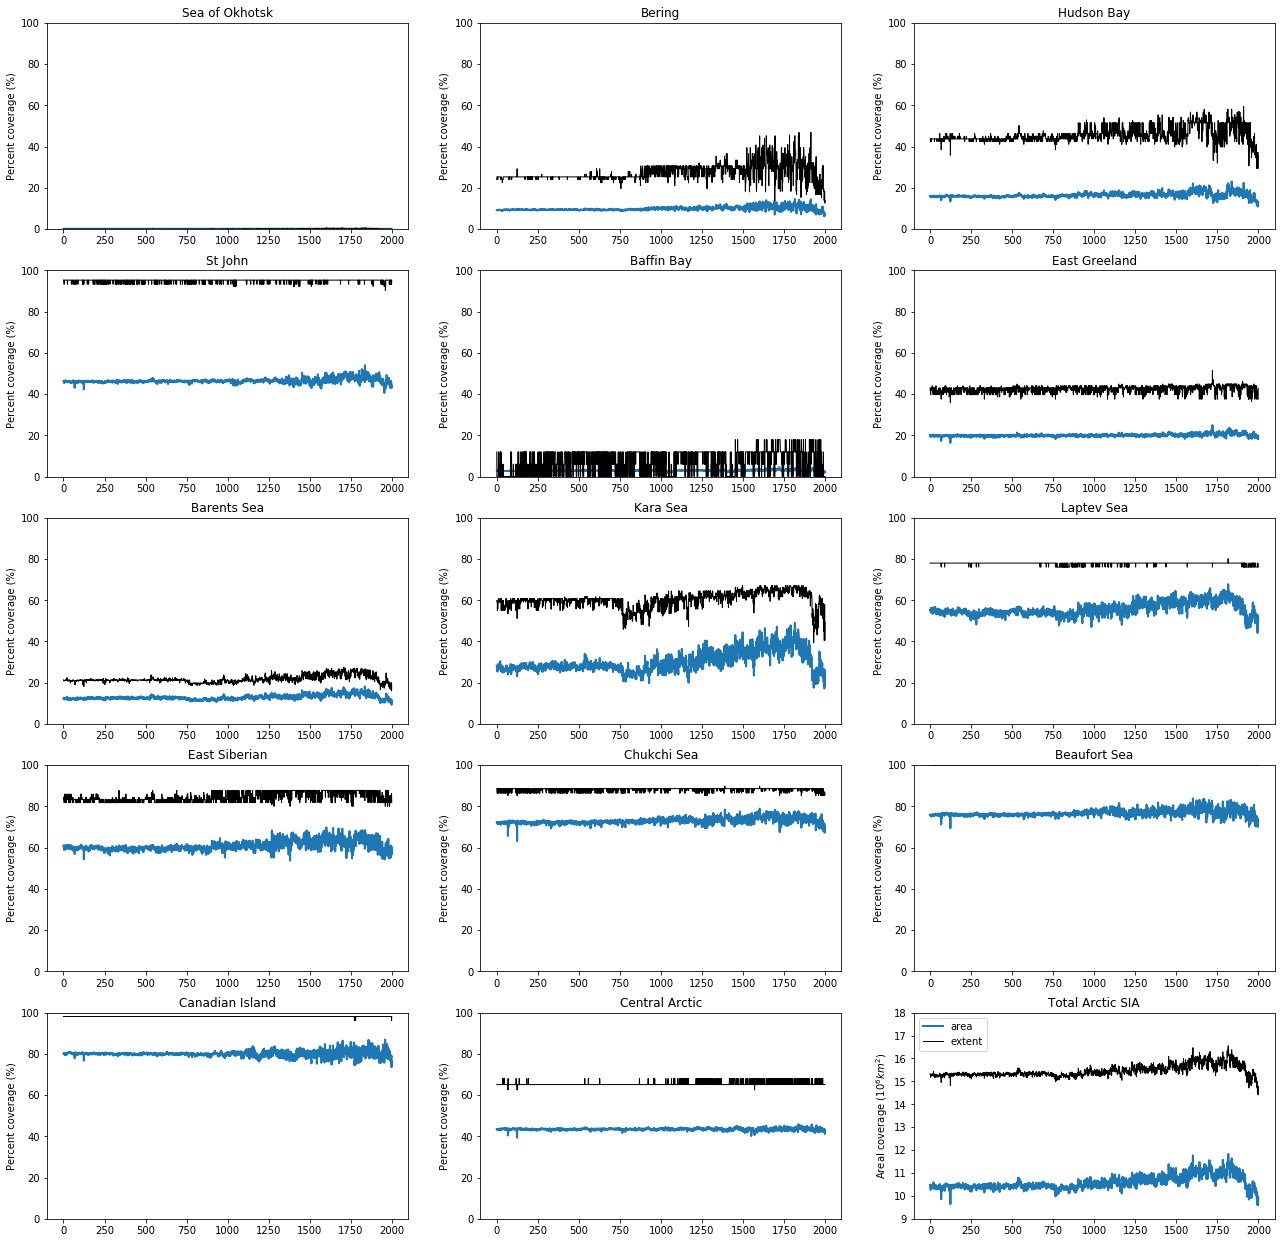

In [299]:
fig,ax = plt.subplots(nrows=5,ncols=3)
fig.set_size_inches(22,22)
ax = ax.flatten()

for ireg,reg in enumerate(regions_list):
    ax[ireg].plot(np.array(recon_years),(regional_sic[reg]/(regional_tot_area[reg]))*100,linewidth=2)
    ax[ireg].plot(np.array(recon_years),(regional_sie[reg]/(regional_tot_area[reg]))*100,
                  linewidth=1,color='k')
    ax[ireg].set_title(reg)
    ax[ireg].set_ylabel('Percent coverage (%)')
    ax[ireg].set_ylim(0,100)
    
ax[-1].plot(np.array(recon_years),sia_ensmn,linewidth=2,label='area')
ax[-1].plot(np.array(recon_years),sie_ensmn,linewidth=1,label='extent',color='k')
ax[-1].legend()
ax[-1].set_title('Total Arctic SIA')
ax[-1].set_ylabel('Areal coverage ($10^6 km^2$)')
ax[-1].set_ylim(9,18)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


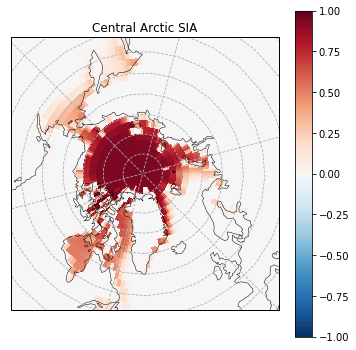

In [300]:
fig,ax = plt.subplots(1,1, figsize=(6, 6), subplot_kw = proj)
sub_arctic_plot(fig,ax,sic_sample.values[0,:,:],
                reg_mask.lat.values,reg_mask.lon.values,
                'Central Arctic SIA',
                1, colorbar=True, extent=True)

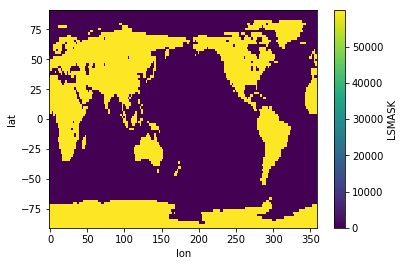

In [301]:
land = xr.open_dataset('/home/disk/p/mkb22/Documents/si_analysis_kb/regridding/LandSeaMask_2x2.nc')
land_mask = xr.where(land.LSMASK == 1.0, 59999, 0)

land_mask.plot()
#land.LSMASK.where(land.LSMASK == 1.0).plot()

In [302]:
sic_land = (sic_sample+land_mask)
sic_land

<xarray.DataArray (time: 2000, lat: 91, lon: 180)>
array([[[5.999900e+04, 5.999900e+04, ..., 5.999900e+04, 5.999900e+04],
        [5.999900e+04, 5.999900e+04, ..., 5.999900e+04, 5.999900e+04],
        ...,
        [9.484600e-01, 9.485593e-01, ..., 9.482803e-01, 9.483669e-01],
        [9.520154e-01, 9.520516e-01, ..., 9.519443e-01, 9.519791e-01]],

       [[5.999900e+04, 5.999900e+04, ..., 5.999900e+04, 5.999900e+04],
        [5.999900e+04, 5.999900e+04, ..., 5.999900e+04, 5.999900e+04],
        ...,
        [9.457365e-01, 9.458007e-01, ..., 9.456292e-01, 9.456797e-01],
        [9.495587e-01, 9.495882e-01, ..., 9.495024e-01, 9.495297e-01]],

       ...,

       [[5.999900e+04, 5.999900e+04, ..., 5.999900e+04, 5.999900e+04],
        [5.999900e+04, 5.999900e+04, ..., 5.999900e+04, 5.999900e+04],
        ...,
        [9.390824e-01, 9.393708e-01, ..., 9.385672e-01, 9.388144e-01],
        [9.421641e-01, 9.422182e-01, ..., 9.420517e-01, 9.421080e-01]],

       [[5.999900e+04, 5.999900e+04, ..

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


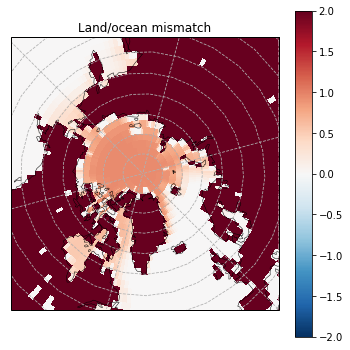

In [323]:
fig,ax = plt.subplots(1,1, figsize=(6, 6), subplot_kw = proj)
sub_arctic_plot(fig,ax,sic_land.values[0,:,:],
                reg_mask.lat.values,reg_mask.lon.values,
                'Land/ocean mismatch',
                2, colorbar=True, extent=True)

# ax.scatter(reg_mask.lon.values[164],reg_mask.lat.values[87],
#            color='teal',transform=ccrs.PlateCarree(), 
#            edgecolors='k',s=50)

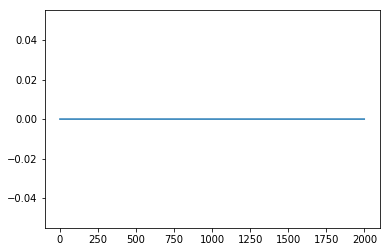

In [322]:
plt.plot(sic_land.values[:,87,164])

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


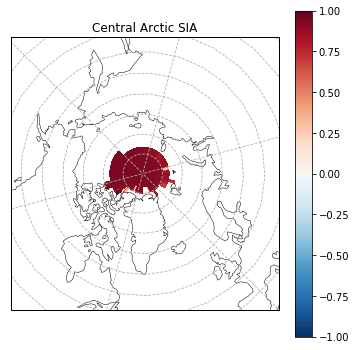

In [304]:
reg_int = 15
areacello_byreg=reg_mask.cell_area.where(reg_mask.region_mask==reg_int)/(1e6)
reg_mask_int = np.where(reg_mask.region_mask==reg_int,1,np.nan)

reg_plot_sic = (reg_mask_int*sic_sample).values
reg_plot_sie = (reg_mask_int*sie_sample).values

area_plot_sic = (sic_sample*areacello_byreg).values
area_plot_sie = (sie_sample*areacello_byreg).values

var = reg_plot_sic[0,:,:]

def plot_arctic(year): 
    fig,ax = plt.subplots(1,1, figsize=(6, 6), subplot_kw = proj)
    sub_arctic_plot(fig,ax,reg_plot_sic[year,:,:],
                    reg_mask.lat.values,reg_mask.lon.values,
                    'Central Arctic SIA',
                    1, colorbar=True, extent=True)
    return 

plot_arctic(1990)

In [244]:
areacello_byreg=reg_mask.cell_area.where(reg_mask.region_mask==13)/(1e6)
reg_plot_sic = (sic_sample*areacello_byreg).values
reg_plot_sie = (sie_sample*areacello_byreg).values

In [214]:
reg_plot_sic.shape, reg_plot_sie.shape

((2000, 91, 180), (91, 180, 2000))

In [218]:
import ipywidgets as widgets
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual

interact(plot_arctic, year=widgets.IntSlider(min=1000, max=1999, step=5))

interactive(children=(IntSlider(value=1000, description='year', max=1999, min=1000, step=5), Output()), _dom_c…

<function __main__.plot_arctic(year)>

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


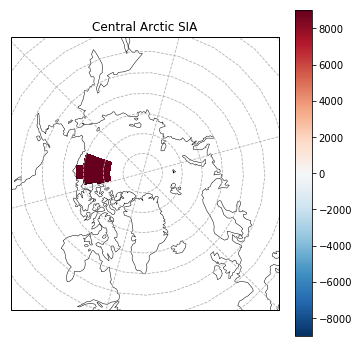

In [245]:
cent_arc = np.where(reg_mask.region_mask==15,1,np.nan)

fig,ax = plt.subplots(1,1, figsize=(6, 6), subplot_kw = proj)
sub_arctic_plot(fig,ax,areacello_byreg.values,
                reg_mask.lat.values,reg_mask.lon.values,
                'Central Arctic SIA',
                9000, colorbar=True, extent=True)

In [246]:
areacello_byreg.sum(dim=['lat','lon'])

<xarray.DataArray ()>
array(890978.117406)

In [250]:
regional_tot_area[list(regional_tot_area.keys())[11]]

array(798272.02001523)

In [249]:
list(regional_tot_area.keys())[11]

'Beaufort Sea   '